Importing the libraries

In [1]:
import numpy as np

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score as roc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import pairwise_kernels as apply_kernel
from shape_dd import shape

import pandas as pd
from copy import deepcopy

import multiprocessing
from multiprocessing.pool import Pool
from tqdm import tqdm
import os
import random
import time


Downloading the dataset

In [19]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("dnkumars/cybersecurity-intrusion-detection-dataset")

# print("Path to dataset files:", path)


In [2]:
data = pd.read_csv("airlines2.csv")


In [3]:
data


,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,target
0,4,269,253,135,3,15,205,1
1,14,1558,217,60,3,15,222,1
2,1,2400,154,80,3,20,165,1
3,1,2466,253,80,3,20,195,1
4,2,108,14,252,3,30,202,0
...,...,...,...,...,...,...,...,...
539378,4,178,203,264,5,1439,326,0
539379,8,398,252,16,5,1439,305,0
539380,8,609,253,184,5,1439,255,0
539381,13,78,128,253,5,1439,313,1


Preprocessing the dataset

In [4]:
X = data.drop(columns=["target"])

# Convert categorical columns to numeric (one-hot encoding)
X = pd.get_dummies(X)

# Convert to NumPy array
X = X.values


In [5]:
X


array([[   4,  269,  253, ...,    3,   15,  205],
       [  14, 1558,  217, ...,    3,   15,  222],
       [   1, 2400,  154, ...,    3,   20,  165],
       ...,
       [   8,  609,  253, ...,    5, 1439,  255],
       [  13,   78,  128, ...,    5, 1439,  313],
       [  14, 1442,  154, ...,    5, 1439,  301]])

Implementing the algorithm

In [6]:
# Inputs:

# X: The data (or an array of indices).
# chunk_size: The size of each batch (window).
# overlap: How much each batch overlaps with the previous one (default is 100).
# How it works:

# Calculates shift, the step size between the start of each batch (shift = chunk_size - overlap).
# Iterates over the data, creating batches of size chunk_size that overlap by overlap samples.
# Each batch is a slice of X from i*shift to min(chunk_size + i*shift, X.shape[0]).
# Appends each batch to the result list res.
# Returns:
# A list of batches (each batch is a slice of X), covering the data with the specified overlap.

def batch(X, chunk_size, overlap=0): # Change overlap to 0
    shift = chunk_size-overlap
    res = []
    for i in range(int(X.shape[0]/(shift))-int(chunk_size/shift)+1):
        res.append( X[i*shift : min(chunk_size + i*shift, X.shape[0])] )
    return res


In [7]:
def run_shape_on_real_data(X, chunk_size):
    t0 = time.time()
    shp = shape(X, 50, chunk_size, 2500)  # Do NOT slice [:,2], keep all columns
    t1 = time.time()
    res = []
    batches = batch(np.arange(X.shape[0]), chunk_size=chunk_size)
    batch_count = len(batches)
    for b in batches:
        res.append({
            "method": "shape",
            "shape_stat_min": float("%.5f" % shp[b, 0].min()),
            "mmd_stat_min": float("%.5f" % shp[b, 1].min()),
            "p_value_min": float("%.5f" % shp[b, 2].min()),
            "chunk_size": chunk_size,
            "comp_time": (t1 - t0) / batch_count
        })
    return res


In [8]:
def run_exp(X, chunk_size):
    # X,y=gen_random(**dict([("dist",dist),("alt",alt),(task,value)  ,  ("length",750),("min_dist",10)]))
    
    t0 = time.time()
    shp = shape(X, 50,chunk_size, 2500)[:,2]
    t1 = time.time()
    
    res = []
    batches = batch(np.arange(X.shape[0]), chunk_size=chunk_size)
    batch_count = len(batches)
    for b in batches:
        x_ = X[b]
        # drift_score = (y[b][None,:] != y[b][:,None]).sum()/( b.shape[0]*(b.shape[0]-1) )
        res += [{"method":method, "estimate":estimate, "chunk_size": chunk_size, "comp_time": comp_time} for method,(comp_time,estimate) in 
               {
                   "shape":        ((t1-t0)/batch_count,float("%.5f"%shp[b].min()))
               }.items()]
    return res


In [9]:
def run_shapedd_streaming(X, window_size=1000, step_size=250, l1=50, n_perm=500):
    """
    Run ShapeDD in a streaming way over X using a sliding window.
    Returns a list of drift results aligned with the center of each window.
    """
    results = []
    positions = []
    
    for i in range(0, len(X) - window_size, step_size):
        window = X[i:i + window_size]
        
        # Run shape only on the window
        res = shape(window, l1=l1, l2=window_size, n_perm=n_perm)
        
        # Record drift decision at the center of the window
        drift_flags = res[:, 2]
        results.append(int(drift_flags.min()))
        positions.append(i + window_size // 2)

    return np.array(positions), np.array(results)


In [ ]:
X = X[:10000]  # Use only the first 1000 rows for testing
res = []
res = run_shape_on_real_data(X, 100)


In [49]:
res


[{'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 0.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 0.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size': 100,
  'comp_time': 0.13905412912368775},
 {'method': 'shape',
  'shape_stat_min': 0.0,
  'mmd_stat_min': 0.0,
  'p_value_min': 1.0,
  'chunk_size':

In [51]:
res2 = run_exp(X, 1000)
res2


[{'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 1.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772},
 {'method': 'shape',
  'estimate': 0.0,
  'chunk_size': 1000,
  'comp_time': 2.644772744178772}]

In [50]:
# Extracting drift_score values
drift_scores = [entry['shape_stat_min'] for entry in res]
print("Drift scores:", drift_scores)


Drift scores: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:
positions, drift_results = run_shapedd_streaming(X, window_size=1000, step_size=500, l1=50, n_perm=250)


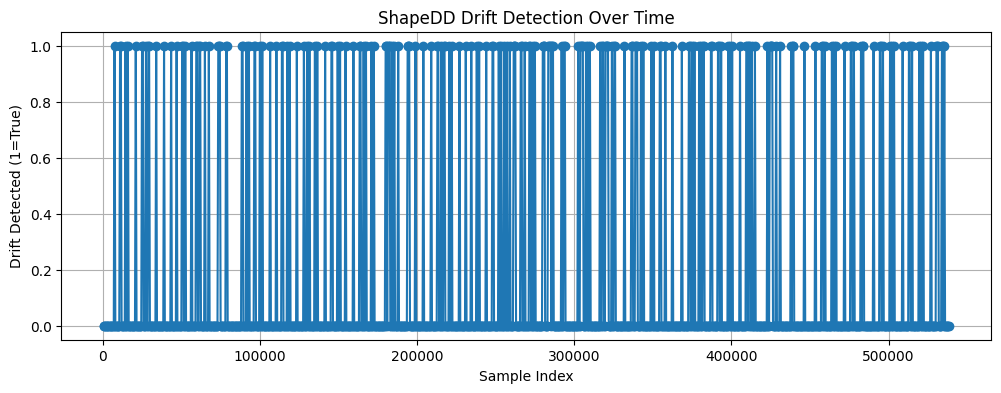

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(positions, drift_results, marker='o', linestyle='-')
plt.title("ShapeDD Drift Detection Over Time")
plt.xlabel("Sample Index")
plt.ylabel("Drift Detected (1=True)")
plt.grid(True)
plt.show()


In [12]:
from sklearn.datasets import load_iris

# Load the iris dataset
iris = load_iris(as_frame=True)
data = iris.frame
X = data.drop(columns=["target"])


In [13]:
data


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [17]:
positions, drift_results = run_shapedd_streaming(X, window_size=50, step_size=25, l1=5, n_perm=250)


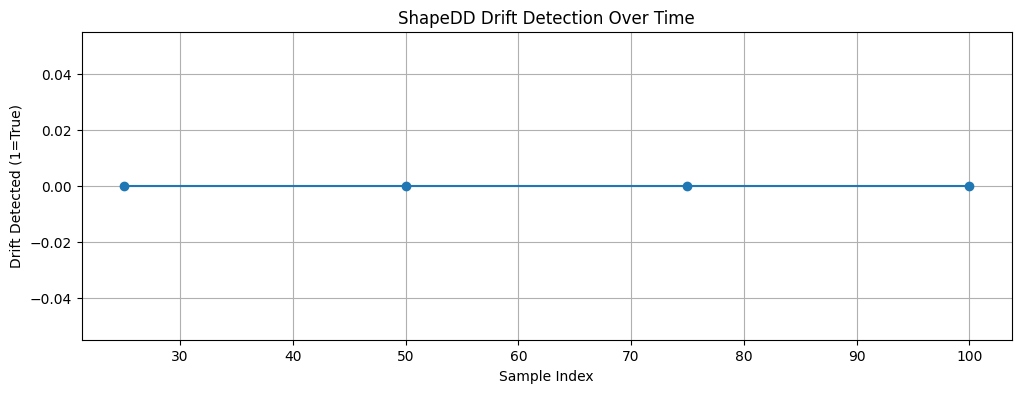

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(positions, drift_results, marker='o', linestyle='-')
plt.title("ShapeDD Drift Detection Over Time")
plt.xlabel("Sample Index")
plt.ylabel("Drift Detected (1=True)")
plt.grid(True)
plt.show()
